In [1]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tqdm.notebook import tqdm

from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from IPython.display import display, Javascript
from base64 import b64decode
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt

## Model Loading

The code loads pre-trained age and gender classification models using Keras. The `load_model` function loads models from files: <span style="color:blue">"Age Model Aug Final.h5"</span> and <span style="color:blue">"Gender Model Final .h5"</span>.

## Face Cascade Classifier

The Haar cascade classifier for detecting frontal faces is loaded using OpenCV's <span style="color:green">`CascadeClassifier`</span> function. The XML file path is obtained from <span style="color:blue">`cv2.data.haarcascades`</span>, and the classifier is stored in <span style="color:blue">`face_cascade`</span>.
pan>.


In [2]:

age_model = load_model("Age Prediction Model.h5",
                                       compile=True)
gender_model = load_model('Gender Prediction Model.h5',
                                       compile=True)


In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade

< cv2.CascadeClassifier 000001B98EAB5A70>

## Age Classification Functions

The `classify_age` function detects faces in an image, predicts their age and gender using pre-trained models, and overlays the predictions on the image.

### Face Detection
- Faces are detected using a Haar cascade classifier.
- Detected faces are outlined with <span style="color:blue">dark blue</span> rectangles.

### Age and Gender Prediction
- Predictions for age and gender are made for each detected face using pre-trained models.
- The predicted age, gender, and confidence percentage are displayed.

### Text Overlay
- Predicted age and gender are overlaid on the image.
- Age predictions are displayed in years with confidence percentages.
- Text backgrounds are <span style="color:blue">dark blue</span>.

## Dynamic Design
- The design is made dynamic to accommodate images of various sizes and aspect ratios.
- Text and rectangles adjust their positions and sizes based on the dimensions of the input image, ensuring consistent and aesthetic overlays.

## Utility Functions

### File Naming
- Functions `new_img_name` and `new_vid_name` generate new file names for analyzed images and videos, respectively.


In [4]:
age_classes=['1-2','3-9','10-20','21-27','28-45','46-65','+66']
gender_classes=['Man','Woman']


In [5]:


def shrink_face_roi(x, y, w, h, scale):
    wh_multiplier = (1-scale)/2
    x_new = int(x + (w * wh_multiplier))
    y_new = int(y + (h * wh_multiplier))
    w_new = int(w * scale)
    h_new = int(h * scale)
    return (x_new, y_new, w_new, h_new)


def create_age_text(img, face_age, face_gender, pct_age, x, y, w, h):
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    text_scale = 1
    age_scale = 0.8
    pct_scale=0.4

    
    gender_text_width=0
    gender_text_height=0
    age_text_width=0
    age_text_height=0
    for i in range(6,30):
        (gender_text_width, gender_text_height), gender_text_bsln = cv2.getTextSize(face_gender, fontFace=fontFace, fontScale=i/10, thickness=2)
        if gender_text_width>= w//4:
            text_scale=(i-1)/10
            gender_text_width=gender_text_width
            gender_text_height=gender_text_height
            break

    for i in range(6,30):
        (age_text_width, age_text_height), age_text_bsln = cv2.getTextSize(face_age, fontFace=fontFace, fontScale=i/10, thickness=1)
        if age_text_width>= (w//18)*9:
            age_text_width=age_text_width
            age_text_height=age_text_height
            age_scale=(i-1)/10
            pct_scale=(i-1)/10
            (pct_text_width, pct_text_height),pct_text_bsln = cv2.getTextSize(pct_age, fontFace=fontFace, fontScale=i/10, thickness=1)
            break




    x_gender_text_org = x+w//56
    y_gender_text_org = int((y + gender_text_height)*1.1)-gender_text_height//3

    x_age_org = x + w -age_text_width
    y_age_org = int(y+h)- int(age_text_height*1.95)

    x_pct_age_org = x_age_org+age_text_width-int(pct_text_width*1.25)
    y_pct_age_org =int( y_age_org* 1.03) 
    gender_rect_top_left = (x, y)
    gender_rect_bottom_right = ((int((x + gender_text_width)*1.02), int((y + gender_text_height)*1.1)))
    age_rect_top_left = (x + w - int(age_text_width*1.1) , y+h-age_text_height*3)
    age_rect_bottom_right = (x + w , int((y+h)))

    face_age_background = cv2.rectangle(img, gender_rect_top_left, gender_rect_bottom_right, (0, 0, 102), cv2.FILLED)
    face_age_background = cv2.rectangle(img, age_rect_top_left, age_rect_bottom_right, (0, 0, 102), cv2.FILLED)

    face_gender_text = cv2.putText(img, face_gender, org=(x_gender_text_org, y_gender_text_org), fontFace=fontFace,
                                   fontScale=text_scale, thickness=2, color=(255, 255, 255), lineType=cv2.LINE_AA)
    face_age_text = cv2.putText(img, face_age, org=(x_age_org, y_age_org), fontFace=fontFace, fontScale=age_scale,
                                thickness=2, color=(255, 255, 255), lineType=cv2.LINE_AA)
    pct_age_text = cv2.putText(img, pct_age, org=(x_pct_age_org, y_pct_age_org), fontFace=fontFace,
                               fontScale=pct_scale, thickness=2, color=(255, 255, 255), lineType=cv2.LINE_AA)

    return (face_age_background, face_age_text, face_gender_text)



def classify_age(img):

    img_copy = np.copy(img)
    img_copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    faces = face_cascade.detectMultiScale(img_copy, scaleFactor=1.2, minNeighbors=6, minSize=(100, 100))

    for i, (x, y, w, h) in enumerate(faces):

        face_rect = cv2.rectangle(img_copy, (x, y), (x+w, int((y+h)*1.2)), (0, 0, 102), thickness=4)
        x2, y2, w2, h2 = shrink_face_roi(x, y-20, w, h, 0.9)
        x3, y3, w3, h3 = shrink_face_roi(x, y-20, w, h, 0.85)

        face_roi_rgb = img_copy_rgb[y2:y2+h2, x2:x2+w2]
        face_roi_gray = img_copy_gray[y3:y3+h3, x3:x3+w3]
        face_roi_rgb = cv2.resize(face_roi_rgb, (218, 178))
        face_roi_gray = cv2.resize(face_roi_gray, (128, 128))


        features_rgb = []
        face_roi_rgb = np.array(face_roi_rgb)
        face_roi_rgb=face_roi_rgb/255
        features_rgb.append(face_roi_rgb)
        features_rgb=np.array(features_rgb)

        features_gray = []
        face_roi_gray = np.array(face_roi_gray)
        face_roi_rgb=face_roi_gray/255
        features_gray.append(face_roi_gray)
        features_gray=np.array(features_gray)

        face_age = age_classes[np.argmax(age_model.predict(features_gray))]
        face_age= face_age+' Years Old'
        face_gender = gender_classes[np.argmax(gender_model.predict(features_rgb))]
        pct_age = np.max(age_model.predict(features_gray))
        pct_age="{:.2f}".format(pct_age)

        face_age_background, face_age_text, face_gender = create_age_text(img_copy, face_age, face_gender, pct_age, x, y, w, (int((y+h)*1.2))-y)

    return img_copy



def new_img_name(org_img_path):
    img_path, img_name_ext = os.path.split(org_img_path)
    img_name, img_ext = os.path.splitext(img_name_ext)

    new_img_name_ext = img_name+"_Analyzed"+img_ext
    new_img_path = os.path.join(img_path, new_img_name_ext)
    
    return new_img_path



def new_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)
    
    new_vid_name_ext = vid_name+"_Analyzed"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)
    return new_vid_path

## Testing

### We will test our model using two pictures of Leonardo DiCaprio: one when he was aged <span style="color:green">13</span> and another when he was <span style="color:green">48</span>.

The model correctly classified the first picture into the age category of <span style="color:green">10-20</span> and the second picture into the age category of <span style="color:green">46-65</span>. 

The model also correctly classified both picture into the gender category of <span style="color:green">Male</span>. 


In [6]:
image_path="Pictures/leo3.jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


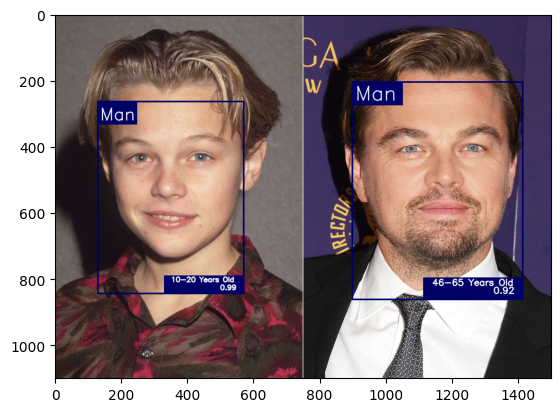

In [7]:


img = cv2.imread(image_path)
age_img = classify_age(img)
plt.imshow(age_img)


In [8]:
try:
    new_my_image = new_img_name(image_path)
    age_img_rgb = cv2.cvtColor(age_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(new_my_image, age_img_rgb)

    print(f"Saved to {new_my_image}")
except:
    print("Error: Could not save image!")



Saved to Pictures\People_Analyzed.jpg


## Testing

### We will test our model usinga video of me: I am <span style="color:green">21</span> years old.

The model correctly classified the video into the age category of <span style="color:green">21-27</span> and into the right gender category.


In [186]:
my_video = "Pictures/Nidhal_video.mp4"

In [187]:

cap = cv2.VideoCapture(my_video)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    if ret==True:
        
        age_img = classify_age(frame)
        age_img = cv2.cvtColor(age_img, cv2.COLOR_BGR2RGB)
       
        out.write(age_img)

    else:
        break

cap.release()
out.release()
print(f"Saved to {new_my_video}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━